In [1]:
import os
import sys
import numpy as np
import re
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

##### Load Drive 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Make a function to Load and Manage Data 

In [68]:
def LoadData(Obj , imgPath = None, maskPath = None, shape =128 ):
    imgNames = os.listdir(imgPath)         #list all the images present in this directory
    maskNames = []                         #maskNames = os.listdir(maskPath)  not using this, because of shuffled data
    
  
    for loc in imgNames:
        maskNames.append(re.sub('\.png', '_seg0.png', loc))    #creating list of all masks in corresponding image wise order           
    imgAddr = imgPath + '/' 
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        image = plt.imread(imgAddr + imgNames[i])                  #generating name of image with path
        mask = plt.imread(maskAddr + maskNames[i])           #mask of image with path
        image = cv2.resize(image, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        Obj['image'].append(image)
        Obj['mask'].append(mask) 
        
    return Obj

In [69]:
Object = {'image' : [],
           'mask' : []
          }

#### Load Data from Drive by providing Path to dataset in LoadData function

In [70]:
Object = LoadData( Object, imgPath ='/content/drive/MyDrive/archive (8)/leedsbutterfly/images', 
                        maskPath = '/content/drive/MyDrive/archive (8)/leedsbutterfly/segmentations'
                         , shape = 128)

#### Plot image and its mask

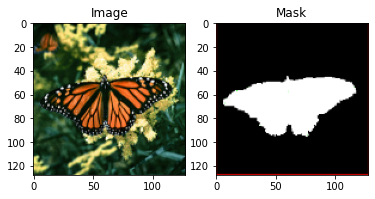

In [100]:
plt.subplot(1,2,1)
plt.imshow(Object['image'][10])
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(Object['mask'][10])
plt.title("Mask")
plt.show()

#### Building U-Net Image Segmentation Model

##### General U-Net Intution
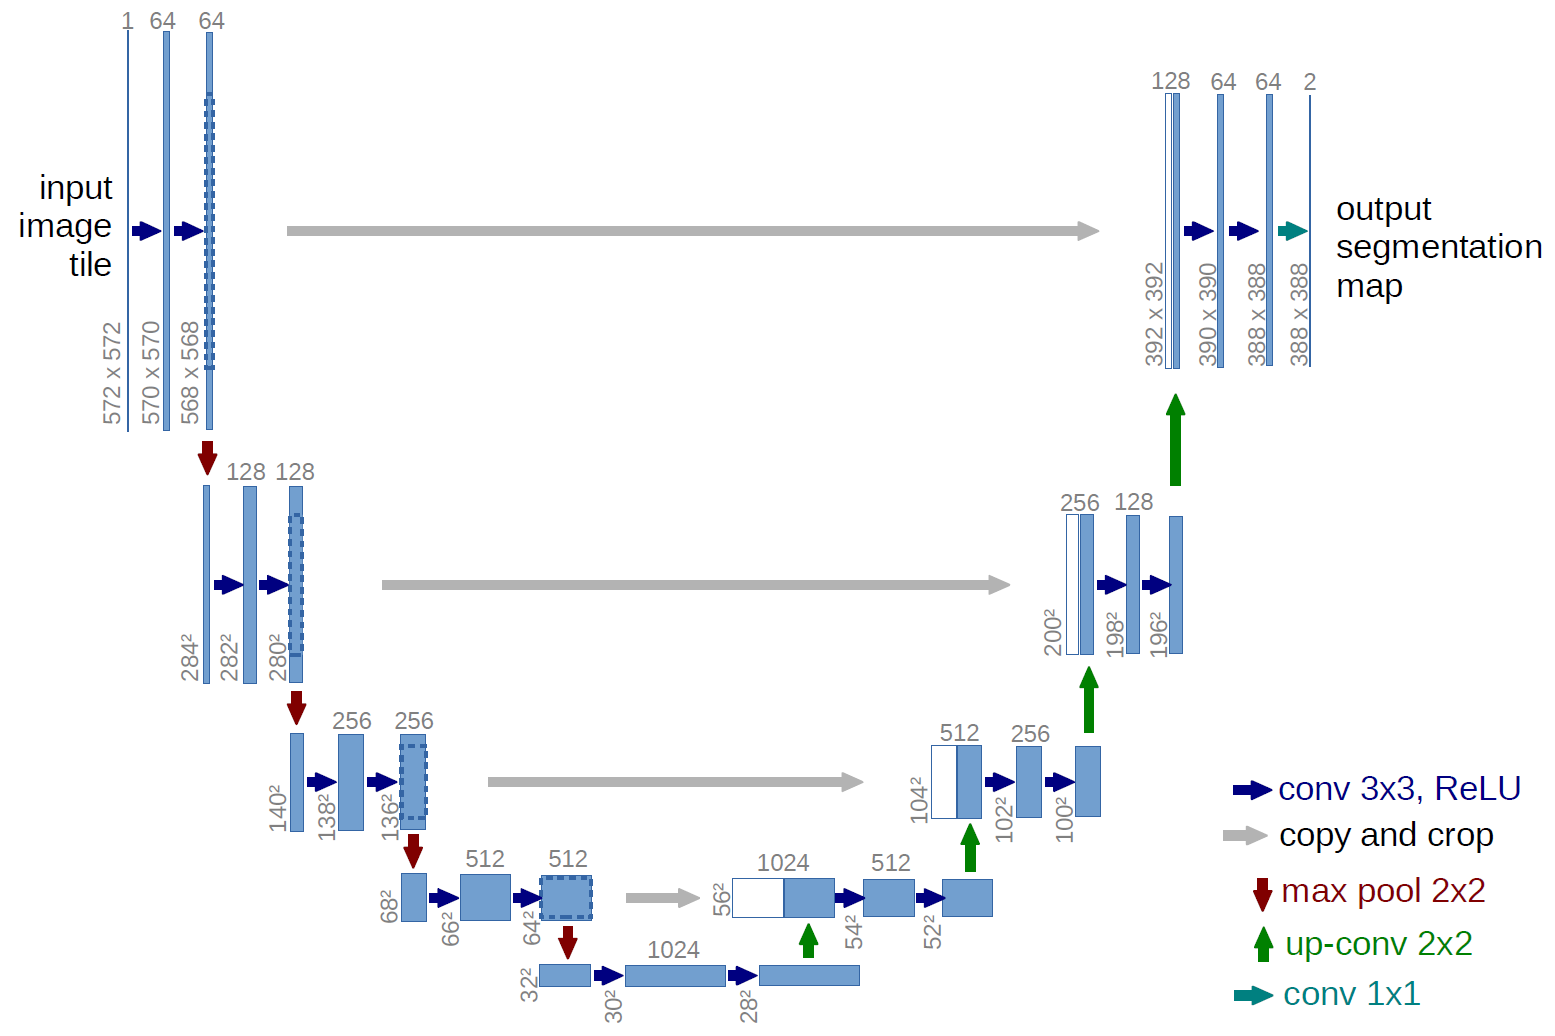



In [20]:
def conv2(inputv , nfilters, kernelsize=3):
    x=tf.keras.layers.Conv2D(nfilters,kernel_size=(kernelsize,kernelsize),padding='same')(inputv)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Activation('relu')(x)
    
    x=tf.keras.layers.Conv2D(nfilters,kernel_size=(kernelsize,kernelsize),padding='same')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Activation('relu')(x)
    
    return x

def unetmodel(inputimage,no_of_filters,dropouts):
    c1=conv2(inputimage,no_of_filters*1,kernelsize=3)
    p1=tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1=tf.keras.layers.Dropout(dropouts)(p1)
    
    c2=conv2(p1,no_of_filters*2,kernelsize=3)
    p2=tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2=tf.keras.layers.Dropout(dropouts)(p2)
    
    c3=conv2(p2,no_of_filters*4,kernelsize=3)
    p3=tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3=tf.keras.layers.Dropout(dropouts)(p3)
    
    c4=conv2(p3,no_of_filters*8,kernelsize=3)
    p4=tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4=tf.keras.layers.Dropout(dropouts)(p4)
    
    c5=conv2(p4,no_of_filters*16,kernelsize=3)
    
    u6=tf.keras.layers.Conv2DTranspose(no_of_filters*8,(3,3),strides=(2,2),padding='same')(c5)
    u6=tf.keras.layers.concatenate([u6,c4])
    u6=tf.keras.layers.Dropout(dropouts)(u6)
    c6=conv2(u6,no_of_filters*8,kernelsize=3)
    
    u7=tf.keras.layers.Conv2DTranspose(no_of_filters*4,(3,3),strides=(2,2),padding='same')(c6)
    u7=tf.keras.layers.concatenate([u7,c3])
    u7=tf.keras.layers.Dropout(dropouts)(u7)
    c7=conv2(u7,no_of_filters*4,kernelsize=3)
    
    u8=tf.keras.layers.Conv2DTranspose(no_of_filters*2,(3,3),strides=(2,2),padding='same')(c7)
    u8=tf.keras.layers.concatenate([u8,c2])
    u8=tf.keras.layers.Dropout(dropouts)(u8)
    c8=conv2(u8,no_of_filters*2,kernelsize=3)
    
    u9=tf.keras.layers.Conv2DTranspose(no_of_filters*1,(3,3),strides=(2,2),padding='same')(c8)
    u9=tf.keras.layers.concatenate([u9,c1])
    u9=tf.keras.layers.Dropout(dropouts)(u9)
    c9=conv2(u9,no_of_filters*1,kernelsize=3)
    
    op=tf.keras.layers.Conv2D(1,(1,1))(c9)
    op=tf.keras.layers.Activation('sigmoid')(op)
    
    unet=tf.keras.Model(inputs=[inputimage],outputs=[op])
    
    return unet

#### Load, Compile and Train

In [22]:
inputs = tf.keras.layers.Input((128, 128, 3))
unet = unetmodel(inputs,16, dropouts= 0.07)
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [24]:
unet.fit(np.array(Object['image']), np.array(Object['mask']), epochs = 60)

Epoch 1/60
12/12 [==============================] - 1s 86ms/step - loss: 0.1692 - accuracy: 0.9460
Epoch 2/60
12/12 [==============================] - 1s 84ms/step - loss: 0.1516 - accuracy: 0.9510
Epoch 3/60
12/12 [==============================] - 1s 84ms/step - loss: 0.1359 - accuracy: 0.9569
Epoch 4/60
12/12 [==============================] - 1s 84ms/step - loss: 0.1277 - accuracy: 0.9573
Epoch 5/60
12/12 [==============================] - 1s 84ms/step - loss: 0.1140 - accuracy: 0.9632
Epoch 6/60
12/12 [==============================] - 1s 84ms/step - loss: 0.1051 - accuracy: 0.9652
Epoch 7/60
12/12 [==============================] - 1s 84ms/step - loss: 0.0994 - accuracy: 0.9661
Epoch 8/60
12/12 [==============================] - 1s 85ms/step - loss: 0.0936 - accuracy: 0.9676
Epoch 9/60
12/12 [==============================] - 1s 84ms/step - loss: 0.0913 - accuracy: 0.9671
Epoch 10/60
12/12 [==============================] - 1s 84ms/step - loss: 0.0858 - accuracy: 0.9684
Epoch 11/

#### Model Predictions 

In [89]:
def predictmask(data, model):
    img = data['image']
    img=np.array(img)
    predictions = model.predict(img)
    return predictions

def Plot_Mask(predictedMask):
    plt.imshow(predictedMask)
    plt.title('Predicted Mask')

In [90]:
Predictions = predictmask(Object, unet)

##### Original Image

Text(0.5, 1.0, 'Image')

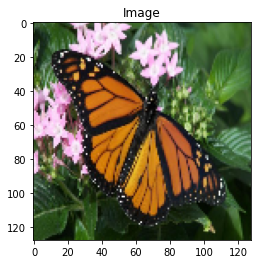

In [99]:
plt.imshow(Object['image'][5])
plt.title("Image")

##### Given Image Mask

Text(0.5, 1.0, 'Given Mask')

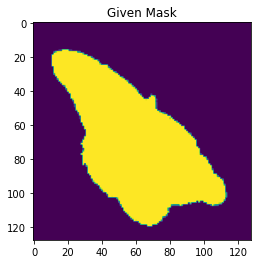

In [98]:
plt.imshow(Object['mask'][5][:,:,0])
plt.title("Given Mask")

##### Predicted Mask

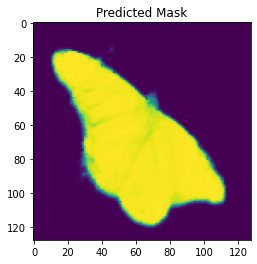

In [92]:
Plotter(Predictions[5][:,:,0])
